In [ ]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
import matplotlib.colors as colors
from scipy.stats import norm
from scipy.optimize import minimize
from jax import hessian

snb.set_theme(font_scale=1.25)

## **Group 13**
- **Mikkel Agerbo Essendrop, s194157**
- **Anton Mosquera Storgaard, s214611**
- **Gustav Hylsberg Jacobsen, s214374**

All group members share equal responsibility for all three parts of this assignment. The work presented here represents a collective effort, and each member has contributed to understanding and completing the tasks.


## Part 1: Gaussian process and covariance functions

in this part, we will study covariance functions for Gaussian process models. We will consider the following 6 covariance functions.

\begin{align}
k_1(x,x') &= 2 \exp\left(-\frac{(x-x')^2}{2 \cdot 0.3^2}\right) \\
k_2(x, x') &=  \exp\left(-\frac{(x-x')^2}{2 \cdot 0.1^2}\right) \\
k_3(x,x') &= 4 + 2xx' \\
k_4(x,x') &= \exp \left(-2 \sin (3 \pi \cdot \vert x-x' \vert )^2 \right) \\
k_5(x,x') &= \exp \left(-2 \sin (3 \pi \cdot \vert x-x' \vert )^2 \right) + 4xx' \\
k_6(x,x') &= \frac{1}{5} + \min(x,x')
\end{align}

$\textbf{Task 1.1}$ Determine the analytical marginal prior mean and variance of a Gaussian process $f_i(x) \sim \mathcal{GP}(0,k_i(x,x'))$ 

This information can be obtained by computing the mean $\mathbb{E}[f_i(x)]$ and variance $\mathbb{V}[f_i(x)]$ for the six covariance functions. It is already given to us that the mean function $m(x)$ is 0 in all instances. Thus we have obtained the mean of the prior, lets now calculate the variance for them all. 
The variance is defined as the case where $x' = x$, just like in a covariance matrix. We substitue that in all our GP's.

\begin{align}
k_1(x,x) &= 2 \exp\left(-\frac{(x-x)^2}{2 \cdot 0.3^2}\right) = 2 \cdot \exp ^0 &= 2 \\
k_2(x,x) &=  \exp\left(-\frac{(x-x)^2}{2 \cdot 0.1^2}\right) = 1 \cdot \exp ^0 &= 1 \\
k_3(x,x) &= 4 + 2xx &= 4 + 2x ^2 \\
k_4(x,x) &= \exp \left(-2 \sin (3 \pi \cdot \vert x-x \vert )^2 \right) = \exp ^{(-2 \cdot \sin(0) ^2)} &= 1 \\
k_5(x,x) &= \exp \left(-2 \sin (3 \pi \cdot \vert x-x \vert )^2 \right) + 4xx  = \exp ^{(-2 \cdot \sin(0) ^2)} + 4x^2  &= 1 + 4x^2  \\
k_6(x,x) &= \frac{1}{5} + \min(x,x) &= \frac{1}{5} + x
\end{align}

$\textbf{Task 1.2}$ Which of the six covariance functions are stationary functions?

A covariance function is stationary if it depends $\textbf{only}$ on the difference between two points in its domain. That means if all expresions include the term $x-x'$. In our case we see that $k_1, k_2 \text{ and } k_4$ would then be stationary where as the remaining 3 are not.

$\textbf{Task 1.3}$ Let $X = \{x_i\}^{100}_{i=1}$ be a sorted set of equidistant point in the interval [0,2]. For each of the six covariance functione sample function values for the covariance matrices evaluated at X.


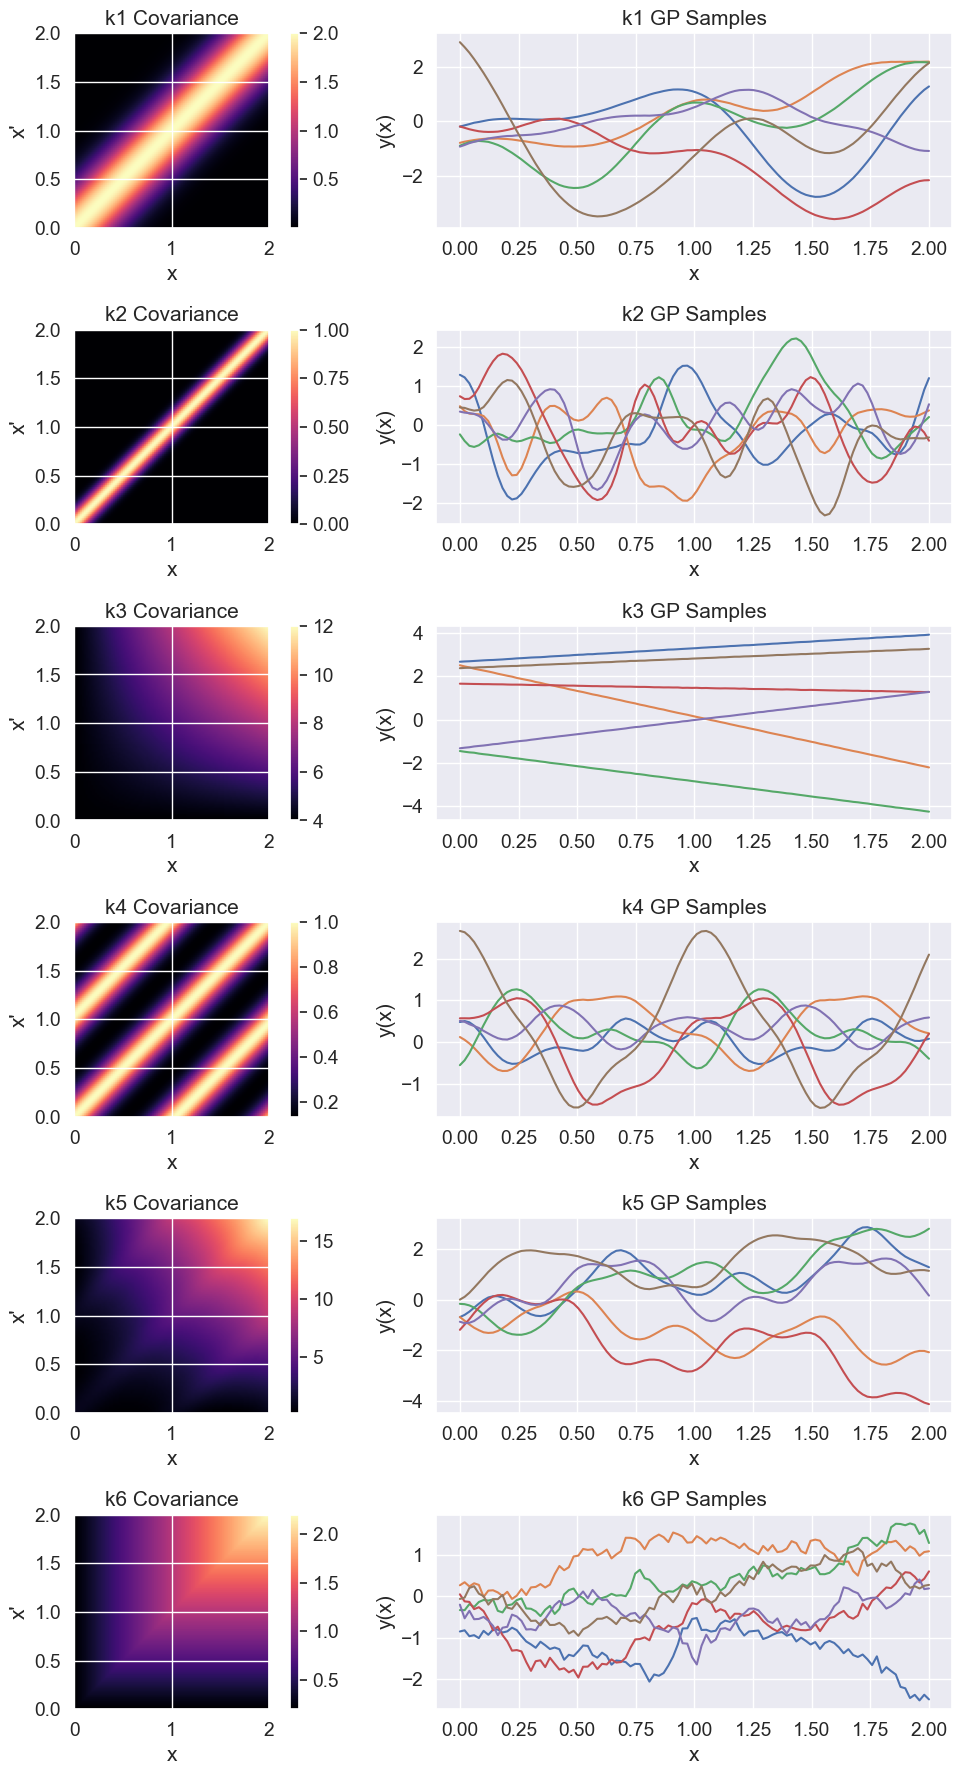

In [5]:
X = np.linspace(0, 2, 100).reshape(-1, 1)

#We start by definning the different covariance functions (kernels) that we will use in the Gaussian processes.
def k1(x1, x2):
    return 2 * np.exp(-(x1 - x2.T) ** 2 / (2 * 0.3 ** 2))

def k2(x1, x2):
    return np.exp(-(x1 - x2.T) ** 2 / (2 * 0.1 ** 2))

def k3(x1, x2):
    return 4 + 2 * x1 @ x2.T

def k4(x1, x2):
    return np.exp(-2 * np.sin(3 * np.abs(x1 - x2.T)) ** 2)

def k5(x1, x2):
    return np.exp(-2 * np.sin(3 * np.abs(x1 - x2.T)) ** 2) + 4 * x1 @ x2.T

def k6(x1, x2):
    return 0.2 + np.minimum(x1, x2.T)

kernels = [k1, k2, k3, k4, k5, k6]
titles = [f"k{i+1}" for i in range(6)]

fig, axes = plt.subplots(6, 2, figsize=(12, 18))
rng = np.random.default_rng(42)

for i, (kernel, title) in enumerate(zip(kernels, titles)):
    K = kernel(X, X)
    #We add a small value to the diagonal to ensure the matrix is positive definite.
    K += 1e-5 * np.eye(len(X))
    
    #We sample from the multivariate normal distribution using the covariance matrix K.
    #Thus generating samples from the Gaussian process.
    samples = rng.multivariate_normal(mean=np.zeros(len(X)), cov=K, size=6)

    ax_cov = axes[i, 0]
    im = ax_cov.imshow(K, cmap="magma", origin="lower", extent=[0, 2, 0, 2])
    ax_cov.set_xlabel("x")
    ax_cov.set_ylabel("x'")
    ax_cov.set_title(f"{title} Covariance")
    plt.colorbar(im, ax=ax_cov, fraction=0.046, pad=0.04)

    ax_gp = axes[i, 1]
    for s in samples:
        ax_gp.plot(X, s)
    ax_gp.set_title(f"{title} GP Samples")
    ax_gp.set_xlabel("x")
    ax_gp.set_ylabel("y(x)")

plt.tight_layout()
plt.show()

Comparing our results above with the ones provided by the assignment we can confirm the following alignment.

\begin{align}
(a) &= k_2 \\
(b) &= k_6 \\
(c) &= k_5 \\
(d) &= k_1 \\
(e) &= k_4 \\
(f) &= k_3
\end{align}

## Part 2 Laplace approximation for a simple neural network

**Task 2.1: Generate $S = 100$ samples from the prior $p(w)$ and plot the corresponding functions
$f(x)$ for $x \in [0, 10]$ on top of a scatter plot of the data.**

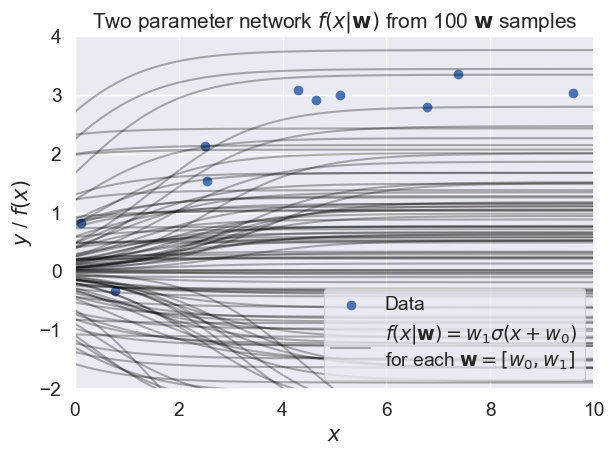

In [6]:
sigmoid = lambda x: 1./(1+jnp.exp(-x))

tau = 2
beta = 4

x_data = jnp.array([9.589, 7.375, 4.647, 2.501, 2.538, 6.783, 4.294, 5.111, 0.130, 0.783])
y_data = jnp.array([3.032, 3.349, 2.906, 2.126, 1.538, 2.787, 3.078, 2.993, 0.828, -0.331])

def f(w,x):
    return w[1]*sigmoid(x+w[0])

w_sample = norm.rvs(size=(100,2), loc=0, scale=tau)

x = jnp.linspace(0,10,1000)
# plot f(x) for each sample of w on top of data
fig, ax = plt.subplots()
ax.scatter(x_data, y_data,label='Data')
for w in w_sample[:-1]:
    ax.plot(x, f(w,x), color='black', alpha=0.3)
ax.plot(x, f(w_sample[-1],x), color='black', alpha=0.3, label=r'$f(x|\mathbf{w}) = w_1\sigma(x+w_0) $'+'\n' + r'for each $\mathbf{w} = [w_0, w_1]$')
ax.set_ylim(-2,4)
ax.set_xlim(0,10)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$ / $f(x)$')
ax.legend(loc='lower right')
# title
plt.title(r'Two parameter network $f(x|\mathbf{w})$ from 100 $\mathbf{w}$ samples')
plt.tight_layout()
plt.show() 


The joint density for $(y,\mathbf{w})$ according to the probabilistic model in eq. (11)-(13) is given
$$
\begin{align}\tag{14}
p(\boldsymbol{y}, \boldsymbol{w})&=p(\boldsymbol{w}) \prod_{n=1}^N p\left(y_n \mid x_n, \boldsymbol{w}\right)\\
&=\mathcal{N}\left(w_0 \mid 0, \tau^2\right) \mathcal{N}\left(w_1 \mid 0, \tau^2\right) \prod_{n=1}^N \mathcal{N}\left(y_n \mid w_1 \sigma\left(x_n+w_0\right), \beta^{-1}\right)\notag
\end{align}
$$

**Task 2.2: What prevents us from using the equations in section 3.3 in Murphy1 to compute
the exact posterior distribution of the parameters given the data analytically for the system
in eq. (14) ?**

The mean of the likelyhood gaussian $f(x)$ is non-linear, hence, we cannot collect the sum of squared exponentials into a linear combination of $w_0$ and $w_1$. It is not possible to derive a Gaussian distribution analytically, through the equations of section 3.3 *Linear Gaussian systems* in Murphy1.

**Task 2.3: Implement a python function for evaluating the logarithm of the joint density in
eq. (14). Report the numerical value of $\text{log}\ p(y,w)$ for the dataset given above when $w_0 = w_1 = 0$.**

$$
\begin{align}
\log p(\mathbf{y},\mathbf{w}) &= \log \left[ \mathcal{N}\left(w_0 \mid 0, \tau^2\right) \mathcal{N}\left(w_1 \mid 0, \tau^2\right) \prod_{n=1}^N \mathcal{N}\left(y_n \mid w_1 \sigma\left(x_n+w_0\right), \beta^{-1}\right)\right]\tag{2.3a}\\
&=
- \frac{2+N}{2}\log (2\pi) - 2\log\tau - \frac{w_0^2+w_1^2}{2\tau^2} + \frac{N}{2}\log \beta - \sum_{n=1}^N \beta\frac{(y_n - w_1 \sigma\left(x_n+w_0\right))^2}{2}\tag{2.3b}
\end{align}
$$

In [7]:
# Testing the analytical expression is derived correctly
def log_joint_from_dist(w, y, x):
    return norm.logpdf(w[0], loc=0, scale=tau) + norm.logpdf(w[1], loc=0, scale=tau) + jnp.sum(norm.logpdf(y, loc=f(w,x), scale=1/jnp.sqrt(beta)))

def log_joint(w, y, x):
    return -(2+len(y))/2*jnp.log(2*jnp.pi) - 2*jnp.log(tau) - (w[0]**2+w[1]**2)/(2*tau**2) + len(y)/2*jnp.log(beta) - jnp.sum(beta*(y-f(w,x))**2)/2

w0 = 0
w1 = 0
print('from log-normal distributions (2.3a):',abs(log_joint_from_dist([w0,w1], y_data, x_data)))
print('from analytical expression (2.3b):',abs(log_joint([w0,w1], y_data, x_data)))

print(f'The two functions differ with {abs(log_joint_from_dist([w0,w1], y_data, x_data) - log_joint([w0,w1], y_data, x_data)):.6f}.')

from log-normal distributions (2.3a): 130.94934
from analytical expression (2.3b): 130.94934
The two functions differ with 0.000000.


**Task 2.4: Determine the expression for the gradient and Hessian of the logarithm of the joint
density wrt. $\mathbf{w}$.**

**The gradient:**

$$\begin{align*}
\nabla_{\mathbf{w}} \log p(\mathbf{y}, \mathbf{w}) &= 
\nabla_{\mathbf{w}} \left( \underbrace{- \frac{2+N}{2}\log (2\pi) - 2\log\tau + \frac{N}{2}\log \beta}_{\text{constant wrt. }\mathbf{w}} - \frac{1}{2\tau^2}\mathbf{w}^T\mathbf{w} - \sum_{n=1}^N \beta\frac{\left(y_n - w_1 \sigma\left(x_n+w_0\right)\right)^2}{2} \right) \\
&=
-\frac{1}{\tau^2} -\frac{\beta}{2} \sum_{n=1}^N \nabla_{\mathbf{w}}\left[y_n^2 - 2 y_n w_1 \sigma\left(x_n+w_0\right) + \left(w_1 \sigma\left(x_n+w_0\right)\right)^2\right]
\end{align*}
$$
To make the derivation simpler, we'll now differentiate the summation term with respect to the two components of $\mathbf{w}$ separately. We'll also denote $\sigma(x+w_0)=\sigma$ and remember that $\partial_x \sigma(x+y) = \sigma(x+y)(1-\sigma(x+y))=\sigma'$.
$$
\begin{align*}
\frac{\partial}{\partial w_0} &\left[ y_n^2 - 2 y_n w_1 \sigma + w_1^2\sigma^2 \right] = - 2 y_n w_1\sigma'+ 2w_1^2\sigma\sigma'

\\
\frac{\partial}{\partial w_1} &\left[  y_n^2 - 2 y_n w_1 \sigma + w_1^2\sigma^2 \right] =
 - 2 y_n\sigma + 2 w_1 \sigma^2
\end{align*}$$

The gradient then becomes
$$
\nabla_{\mathbf{w}} \log p(\mathbf{y}, \mathbf{w})=
-\frac{1}{\tau^2}\mathbf{w} -\beta \sum_{n=1}^N
\begin{pmatrix} - y_n w_1\sigma'+ w_1^2\sigma\sigma' \\ - y_n\sigma + w_1 \sigma^2 \end{pmatrix}
$$



In [8]:
### testing the gradient with point on plot
w_MAP = minimize(lambda w: -log_joint(w, y_data, x_data), jnp.array([-2,3]),method='Nelder-Mead').x

def gradient(w0, w1, y, x):

    sigma = sigmoid(x+w0)

    return -(w0+w1)/(tau**2) - beta*jnp.sum(-(1+w1)*y*sigma+(w1+w1*y+w1**2)*sigma**2-w1**2*sigma**3)

print('MAP estimate:',w_MAP)
print('Gradient:',gradient(w_MAP[0],w_MAP[1],y_data,x_data))


MAP estimate: [-2.20425029  3.10427369]
Gradient: -0.0027785152


The gradient of the log joint is close to 0 around the maximum illustated in the contour plot below.

**The Hessian:**
$$ \begin{align*}
\mathcal{H}(\textbf{w}) = \sum_{i,j} \frac{\partial^2}{\partial w_i \partial w_j} \log p(\mathbf{y}, \mathbf{w}) = \nabla_{\mathbf{w}}\left(\nabla_{\mathbf{w}} \log p(\mathbf{y}, \mathbf{w})\right)= \nabla_{\mathbf{w}} \left[-\frac{1}{\tau^2}\mathbf{w} -\beta \sum_{n=1}^N
\begin{pmatrix} - y_n w_1\sigma'+ w_1^2\sigma\sigma' \\ - y_n\sigma + w_1 \sigma^2 \end{pmatrix} \right]\\
\end{align*}$$

The partial derivatives:
$$
\begin{align*}
-\frac{1}{\tau^2}\begin{pmatrix}1\\0\end{pmatrix}-\beta \sum_{n=1}^N\frac{\partial}{\partial w_0}  \begin{pmatrix} - y_n w_1\sigma'+ w_1^2\sigma\sigma' \\ - y_n\sigma + w_1 \sigma^2 \end{pmatrix}
&=
-\frac{1}{\tau^2}\begin{pmatrix}1\\0\end{pmatrix}-\beta \sum_{n=1}^N\begin{pmatrix} - w_1y_n\sigma'' + w_1^2\sigma'\sigma' +w_1^2\sigma\sigma''  \\ - y_n \sigma' + 2w_1\sigma\sigma' \end{pmatrix}
\\

\\

-\frac{1}{\tau^2}\begin{pmatrix}0\\1\end{pmatrix}-\beta \sum_{n=1}^N\frac{\partial}{\partial w_1} \begin{pmatrix} - y_n w_1\sigma'+ w_1^2\sigma\sigma' \\ - y_n\sigma + w_1 \sigma^2 \end{pmatrix}
&=
-\frac{1}{\tau^2}\begin{pmatrix}0\\1\end{pmatrix}-\beta \sum_{n=1}^N\begin{pmatrix}  - y_n\sigma'+ 2w_1\sigma\sigma' \\ \sigma^2 \end{pmatrix}
\end{align*}$$

Plugging in the expressions for the partial derivatives, we get the hessian
$$
\begin{align*}
\mathcal{H}(\textbf{w}) = -\frac{1}{\tau^2}\begin{pmatrix}1&0\\0&1\end{pmatrix}-\beta\sum_{i=1}^N

\begin{pmatrix} - w_1y_n\sigma'' + w_1^2\sigma'\sigma' +w_1^2\sigma\sigma''  & - y_n \sigma' + 2w_1\sigma\sigma'\\
- y_n\sigma'+ 2w_1\sigma\sigma'  & \sigma^2
\end{pmatrix}
\end{align*}
$$



In [9]:

def Hessian(w, y, x):
    sigma = sigmoid(x+w[0])
    sigma_m = sigma*(1-sigma)
    sigma_mm = sigma_m*(1-2*sigma)

    H = np.zeros((2,2))

    tau_sq_inv = (1/tau**2)

    H[0,0] = - beta*np.sum(-w[1]*y*sigma_mm + w[1]**2*sigma_m**2 +w[1]**2*sigma*sigma_mm)
    H[0,1] = - beta*np.sum(-y*sigma_m +2*w[1]*sigma*sigma_m)
    H[1,0] = H[0,1]
    H[1,1] = - beta*np.sum(sigma**2)

    H += -tau_sq_inv*np.eye((2)) 
    return H

hessian_func = hessian(lambda w: log_joint(w, y_data, x_data))

print('Hessian from jax library:\n',hessian_func(w_MAP)[:,:])
#print('Hessian from hessian function:',hessian_sum([-2.20005,3.102]))
print('Hessian from analytical expression:\n',Hessian(w_MAP,y_data,x_data))

Hessian from jax library:
 [[ -7.853787  -6.897481]
 [ -6.897481 -25.144207]]
Hessian from analytical expression:
 [[ -7.85378599  -6.89748144]
 [ -6.89748144 -25.144207  ]]


Hessian of log joint is negative around the extremum, hence we could be near a local maximum.

**Task 2.5: Determine the Laplace approximation $q(w)$ of the posterior distribution such that
$p(w|y) \approx q(w)$.**

The Laplace approximation assumes that we can fit a gaussian to the posterior distribution locally at the MAP with variance corresponding to the inverse, negative hessian of the logaritmic joint distribution.
$$
p(\mathbf{w}|\mathbf{y})\approx q(\mathbf{w})=\mathcal{N}\left(\mathbf{w}|\mathbf{w}_{\text{MAP}},\left[-\mathcal{H(\mathbf{w}_{\text{MAP}})}\right]^{-1} \right)
$$
with
$$
\mathbf{w}_{\text{MAP}} = \begin{pmatrix} -2.204 \\ 3.104\end{pmatrix}, \ \ \ \ \mathcal{H(\mathbf{w}_{\text{MAP}})} = \begin{pmatrix} -7.854  & -6.897\\ -6.897 & -25.144\end{pmatrix},\ \ \ \ \left[-\mathcal{H(\mathbf{w}_{\text{MAP}})}\right]^{-1} = \begin{pmatrix} 0.168  & - 0.046\\ -0.046 & 0.052
\end{pmatrix}
$$
Finding the argument for maximizing the log joint distribution, we can then evaluate the Hessian in that point giving us the following Laplace approximation:


In [10]:
w_MAP = minimize(lambda w: -log_joint(w, y_data, x_data), jnp.array([-2,3]),method='Nelder-Mead').x
log00 = log_joint(w_MAP,y_data,x_data)
print('w_MAP estimate:\n',jnp.round(w_MAP,3))
print('\nMAP log joint:\n',jnp.round(log00,2))
print('\nMAP negative Hessian:\n',np.round(-Hessian(w_MAP,y_data,x_data),3))
print('\ninverse negative Hessian:\n',np.round(jnp.linalg.inv(-Hessian(w_MAP,y_data,x_data)),3))

w_MAP estimate:
 [-2.204  3.104]

MAP log joint:
 -10.41

MAP negative Hessian:
 [[ 7.854  6.897]
 [ 6.897 25.144]]

inverse negative Hessian:
 [[ 0.16800001 -0.046     ]
 [-0.046       0.052     ]]


**Task 2.6: Create a 2D contour plot of posterior distribution of the parameters. Plot the
contours of the Laplace approximation on top of the plot to validate your results from the
previous tasks.**

In [11]:
def f_grid(w,x):
    return w[1]*sigmoid(x[:,None,None]+w[0])

def log_joint(w, y, x):
    N= len(y)
    return -(2+N)/2*jnp.log(2*jnp.pi) - 2*jnp.log(tau) - (w[0]**2+w[1]**2)/(2*tau**2) + N/2*jnp.log(beta) - beta*jnp.sum((y[:,None,None]-f_grid(w,x))**2,axis=0)/2

def log_q(w,w_MAP,H,H_inv):
    w_diff = w - w_MAP
    return -jnp.log(2*jnp.pi) - 0.5*w_diff@H@w_diff.T - 0.5*jnp.log(jnp.linalg.det(H_inv))

C:\Users\anton\AppData\Local\Temp\ipykernel_8676\3895552879.py:22: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(w0_grid, w1_grid, log_q_grid, levels=20,colors='red', alpha=0.5, linestyles='solid',label='log q')


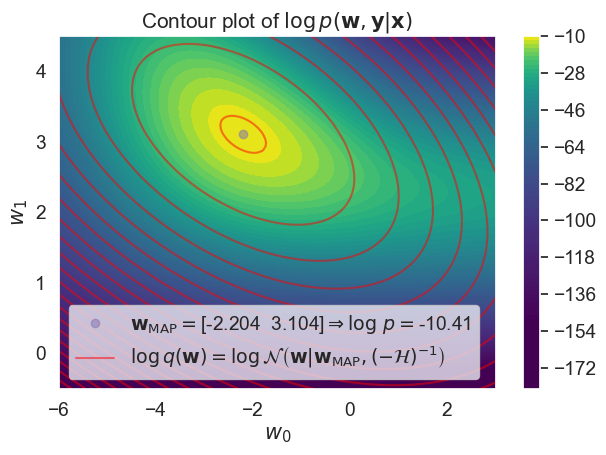

In [12]:
# plot contour of log joint
w0 = jnp.linspace(-6,3,100)
w1 = jnp.linspace(-0.5,4.5,100)

A = -Hessian(w_MAP,y_data,x_data)
A_inv = jnp.linalg.inv(-Hessian(w_MAP,y_data,x_data))
w_MAP = minimize(lambda w: -log_joint(w, y_data, x_data), jnp.array([-2,3]),method='Nelder-Mead').x
log00 = log_joint(w_MAP,y_data,x_data)

grid_size = (len(w0), len(w1))
w0_grid, w1_grid = jnp.meshgrid(w0,w1)
params_flat= jnp.column_stack((w0_grid.flatten(), w0_grid.flatten()))
log_joint_grid = log_joint([w0_grid, w1_grid],y_data,x_data).squeeze().reshape(grid_size)
log_q_grid = jnp.vectorize(lambda x0, x1: log_q(jnp.array([x0, x1]), w_MAP, A,A_inv))(w0_grid, w1_grid)

fig, ax = plt.subplots()

# log joint
c = ax.contourf(w0_grid, w1_grid, log_joint_grid, levels=100,cmap='viridis' , norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=-150, vmax=-10))
# log q
fig.colorbar(c, ax=ax)
ax.contour(w0_grid, w1_grid, log_q_grid, levels=20,colors='red', alpha=0.5, linestyles='solid',label='log q')
ax.plot(w_MAP[0],w_MAP[1], 'o', color='m', alpha=0.5,label=r'$\mathbf{w}_{\text{MAP}}=$'+f'{jnp.round(w_MAP,3)}'+ r'$\Rightarrow \text{log }p=$'+f'{log00[0,0]:.2f}')
ax.plot(w_MAP[0],w_MAP[1], '-', color='red', alpha=0.5, label=r'$\log q(\mathbf{w})=\log \mathcal{N}\left(\mathbf{w}|\mathbf{w}_{\text{MAP}},\left(-\mathcal{H}\right)^{-1}\right)$')

ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
ax.legend(loc='lower left')
plt.title(r'Contour plot of $\log p(\mathbf{w},\mathbf{y}|\mathbf{x})$')
plt.tight_layout()
plt.show()


**Task 2.7: Generate and plot $S = 100$ samples from the approximate posterior distribution. Plot
the corresponding function $f(x)$ for $x \in [0, 10]$ on top of a scatter plot of the data.**

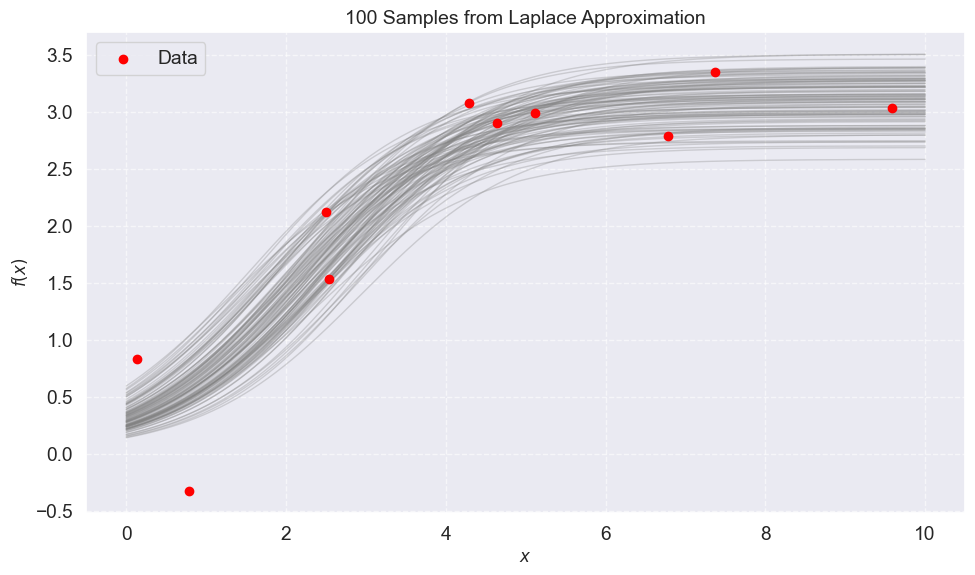

In [13]:

max_idx = jnp.unravel_index(jnp.argmax(log_joint_grid), log_joint_grid.shape)
# Hessian and covariance


# Sample from Laplace approximation*
S = 100
samples = np.random.multivariate_normal(mean=w_MAP, cov=A_inv, size=S)

# Generate function curves from samples
x_plot = jnp.linspace(0, 10, 300)
f_samples = jnp.array([f(w, x_plot) for w in samples])

# Plot
plt.figure(figsize=(10, 6))

# Plot all sampled functions
for f_s in f_samples:
    plt.plot(x_plot, f_s, color='gray', alpha=0.3, linewidth=1)

# Overlay data
plt.scatter(x_data, y_data, color='red', label='Data', zorder=5)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$f(x)$', fontsize=12)
plt.title(f'{S} Samples from Laplace Approximation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

**Task 2.8: Use the Laplace approximation to compute the (approximate) posterior probability
for the event $f(8) > 3$.**

In [14]:
S = 10000  # Large number for better estimate
samples = np.random.multivariate_normal(mean=w_MAP, cov=A_inv, size=S)

# Compute f(8) for all samples
x_val = 8.0
f_8_samples = jnp.array([w[1] * sigmoid(x_val + w[0]) for w in samples])

# Estimate P(f(8) > 3)
prob_f8_gt_3 = jnp.mean(f_8_samples > 3)

print(f"Approximate posterior probability that f(8) > 3: {prob_f8_gt_3:.4f}")

Approximate posterior probability that f(8) > 3: 0.6575
